In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/jbloomAus/SAELens
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")
    

import torch
import transformer_lens.utils as utils
import plotly.express as px
import tqdm
from functools import partial
import einops
import plotly.graph_objects as go

update_layout_set = {
    "xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis",
     "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid",
     "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth"
}

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    if isinstance(tensor, list):
        tensor = torch.stack(tensor)
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "facet_labels" in kwargs_pre:
        facet_labels = kwargs_pre.pop("facet_labels")
    else:
        facet_labels = None
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0,labels={"x":xaxis, "y":yaxis}, **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label

    fig.show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, return_fig=False, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    fig = px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs)
    if return_fig:
        return fig
    fig.show(renderer)

from typing import List
def show_avg_logit_diffs(x_axis: List[str], per_prompt_logit_diffs: List[torch.tensor]):
    y_data = [per_prompt_logit_diff.mean().item() for per_prompt_logit_diff in per_prompt_logit_diffs]
    error_y_data = [per_prompt_logit_diff.std().item() for per_prompt_logit_diff in per_prompt_logit_diffs] 

    fig = go.Figure(data=[go.Bar(
        x=x_axis,
        y=y_data,
        error_y=dict(
            type='data',  # specifies that the actual values are given
            array=error_y_data,  # the magnitudes of the errors
            visible=True  # make error bars visible
        ),
    )])

    # Customize layout
    fig.update_layout(title_text=f'Logit Diff after Interventions',
                    xaxis_title_text='Intervention',
                    yaxis_title_text='Logit diff',
                    plot_bgcolor='white')

    # Show the figure
    fig.show()

if torch.cuda.is_available():
    device = "cuda"
# elif torch.backends.mps.is_available():
#     device = "mps"
else: 
    device = "cpu"
torch.set_grad_enabled(False)
!nvidia-smi

Running as a Jupyter notebook - intended for development only!


/tmp/ipykernel_3317247/1470872126.py:15: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_3317247/1470872126.py:16: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


Sun Jul  7 04:51:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:86:00.0 Off |                    0 |
| N/A   34C    P0              35W / 250W |      3MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from sae_lens import HookedSAETransformer
model_gemma: HookedSAETransformer = HookedSAETransformer.from_pretrained("gemma-2b").to(device)

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer
Moving model to device:  cuda


In [3]:
from sae_lens import SAE 
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

# Choose a layer you want to focus on
# For this tutorial, we're going to use layer 2
layer = 6

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-2b-res-jb",
    sae_id = f"blocks.{layer}.hook_resid_post",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

blocks.6.hook_resid_post


In [81]:
def test_performance(prompt_list, answer_list, model, max_new_tokens=1, temperature=0.4):
    tokens = model.to_tokens(prompt_list, prepend_bos=True)
    op = model.generate(tokens, max_new_tokens=1, temperature=0.4)
    corr = 0
    for ind, val in enumerate(prompt_list):
        print("Prompt: "+val)
        print("Expected Answer: "+answer_list[ind])
        print("Model Answer: "+ model.to_string(op[ind, -1]))
        if answer_list[ind] == model.to_string(op[ind, -1]):
            corr+=1
    print("Accuracy: ", corr*100/len(prompt_list))

def logit_difference(model, answers, prompts):
    # Convert prompts to tokens
    tokens = model.to_tokens(prompts)
    logits, _ = model.run_with_cache(tokens)
    
    # Get the correct tokens for all answers at once
    correct_tokens = model.to_tokens(answers).squeeze()[:, 1]  # Select the second token (correct token) in each sequence

    # Get the logits for the last token of each prompt
    last_logits = logits[:, -1, :]

    # Get the most probable token indices for all prompts at once
    most_probable_token_indices = torch.argmax(last_logits, dim=-1)

    # Gather the logits for the most probable tokens and the correct tokens
    most_probable_logits = last_logits.gather(1, most_probable_token_indices.unsqueeze(1)).squeeze(1)
    correct_logits = last_logits.gather(1, correct_tokens.unsqueeze(1)).squeeze(1)

    # Calculate the logit differences
    logit_differences = most_probable_logits - correct_logits
    return logit_differences

def logit_difference_sae(model, answers, prompts):
    # Convert prompts to tokens
    hooked_saes = [hook_name_to_sae["blocks.6.hook_resid_post"]]
    
    tokens = model.to_tokens(prompts)
    logits = model.run_with_saes(tokens, saes=hooked_saes)
    
    # Get the correct tokens for all answers at once
    correct_tokens = model.to_tokens(answers).squeeze()[:, 1]  # Select the second token (correct token) in each sequence

    # Get the logits for the last token of each prompt
    last_logits = logits[:, -1, :]

    # Get the most probable token indices for all prompts at once
    most_probable_token_indices = torch.argmax(last_logits, dim=-1)

    # Gather the logits for the most probable tokens and the correct tokens
    most_probable_logits = last_logits.gather(1, most_probable_token_indices.unsqueeze(1)).squeeze(1)
    correct_logits = last_logits.gather(1, correct_tokens.unsqueeze(1)).squeeze(1)

    # Calculate the logit differences
    logit_differences = most_probable_logits - correct_logits
    return logit_differences

import random
import string

def generate_sequences(num_samples):
    sequences = []
    answers = []

    for _ in range(num_samples):
        letters = random.sample(string.ascii_uppercase, 4)
        random.shuffle(letters)
        
        prompts = [
            f"If {letters[2]} leads to {letters[3]}, {letters[1]} leads to {letters[2]}, and {letters[0]} leads to {letters[1]}, then {letters[0]} will eventually lead to <strong>"
        ]
        
        sequences.append(prompts[0])
        answers.append(letters[3])

    return sequences, answers

prompts_5, answers_5 = generate_sequences(50)

# Iterate trhough top vectors to find which works

In [82]:
def logit_difference_steered(model, logits, answers, prompts):
    
    # Get the correct tokens for all answers at once
    correct_tokens = model.to_tokens(answers).squeeze()[:, 1]  # Select the second token (correct token) in each sequence

    # Get the logits for the last token of each prompt
    last_logits = logits[:, -1, :]

    # Get the most probable token indices for all prompts at once
    most_probable_token_indices = torch.argmax(last_logits, dim=-1)

    # Gather the logits for the most probable tokens and the correct tokens
    most_probable_logits = last_logits.gather(1, most_probable_token_indices.unsqueeze(1)).squeeze(1)
    correct_logits = last_logits.gather(1, correct_tokens.unsqueeze(1)).squeeze(1)

    # Calculate the logit differences
    logit_differences = most_probable_logits - correct_logits
    return logit_differences

In [83]:
# take prompts get sae Out
# for top 50 features 
# iterate through all 50 with coeff = [5, 50, 150]
# Have function to check performance 

sv_prompt = prompts_5[0]
sv_logits, cache = model_gemma.run_with_cache(sv_prompt, prepend_bos=True)
tokens = model_gemma.to_tokens(sv_prompt)
print(tokens)

# get the feature activations from our SAE
sv_feature_acts = sae.encode(cache[hook_point])

# get sae_out
sae_out = sae.decode(sv_feature_acts)

# print(torch.topk(sv_feature_acts, 3))


tensor([[     2,   2495,    585,  11845,    577,    752, 235269,    584,  11845,
            577,    585, 235269,    578,   1576,  11845,    577,    584, 235269,
           1492,   1576,    877,  13339,   2389,    577, 235248,    199]],
       device='cuda:0')


In [84]:
top_features = torch.topk(sv_feature_acts, 50).indices.tolist()

In [85]:
from collections import Counter

def sort_by_frequency(nested_list):
    # Flatten the nested list
    flat_list = [item for sublist in nested_list for item in sublist]
    
    # Count the frequency of each element
    frequency_count = Counter(flat_list)
    
    # Sort elements by frequency (most frequent first) and then by the element value (if frequencies are the same)
    sorted_elements = sorted(frequency_count.keys(), key=lambda x: (-frequency_count[x], x))
    
    return sorted_elements

sorted_unique_elements = sort_by_frequency(top_features[0])
print(len(sorted_unique_elements))

514


In [86]:
result_dict = {}

for feature_ind in sorted_unique_elements[:100]:
    coeff_dict = {}
    for coeff in [5, 50, 150]:
        # dict_key = str(feature_ind)+"_"+str(coeff)
        steering_vector = sae.W_dec[feature_ind]
        def steering_hook(resid_pre, hook):
            if resid_pre.shape[1] == 1:
                return

            position = sae_out.shape[1]
            if steering_on:
              # using our steering vector and applying the coefficient
              resid_pre[:, :position - 1, :] += coeff * steering_vector

        def hooked_generate(prompt_batch, fwd_hooks=[], seed=None):
            if seed is not None:
                torch.manual_seed(seed)

            with model_gemma.hooks(fwd_hooks=fwd_hooks):
                tokenized = model_gemma.to_tokens(prompt_batch)
                result, _ = model_gemma.run_with_cache(tokenized)
            return result
        
        model_gemma.reset_hooks()
        editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
        logits = hooked_generate(prompts_5, editing_hooks, seed=None)
        coeff_dict[coeff] = logit_difference_steered(model_gemma, logits, answers_5, prompts_5)
        # Free up memory
        del logits
        torch.cuda.empty_cache()
    result_dict[feature_ind] = coeff_dict 

In [ ]:
result_dict

In [60]:
torch.save(result_dict, "steered_logit_diff.pth")

In [87]:
base_logit_diff = logit_difference(model_gemma, answers_5, prompts_5)

In [62]:
torch.save(base_logit_diff, "base_logit_diff.pth")

In [88]:
baseline_avg = base_logit_diff.mean().item()

In [91]:
baseline_avg

0.3152427673339844

In [89]:
import matplotlib.pyplot as plt
# Dictionary to store average values
avg_dict = {}

# Calculate averages
for feature_ind, coeff_dict in result_dict.items():
    avg_dict[feature_ind] = {}
    for coeff, tensor in coeff_dict.items():
        avg_dict[feature_ind][coeff] = tensor.mean().item()


In [92]:
# Find the N feature indices with the lowest averages
N = 5  # Number of lowest averages to find
feature_min_avg_list = []

for feature_ind, coeff_dict in avg_dict.items():
    min_avg_value = min(coeff_dict.values())
    feature_min_avg_list.append((feature_ind, min_avg_value))

# Sort the features by their minimum average values
feature_min_avg_list.sort(key=lambda x: x[1])

# Get the N lowest averages
lowest_avg_features = feature_min_avg_list[:N]

print(f"The {N} feature indices with the lowest minimum average values are:")
for feature_ind, avg_value in lowest_avg_features:
    print(f"{feature_ind}: {avg_value}")



The 5 feature indices with the lowest minimum average values are:
2605: 0.0029293058905750513
3201: 0.007526702713221312
12777: 0.016594504937529564
13939: 0.019126547500491142
3549: 0.0197586826980114


/tmp/ipykernel_3317247/899016226.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


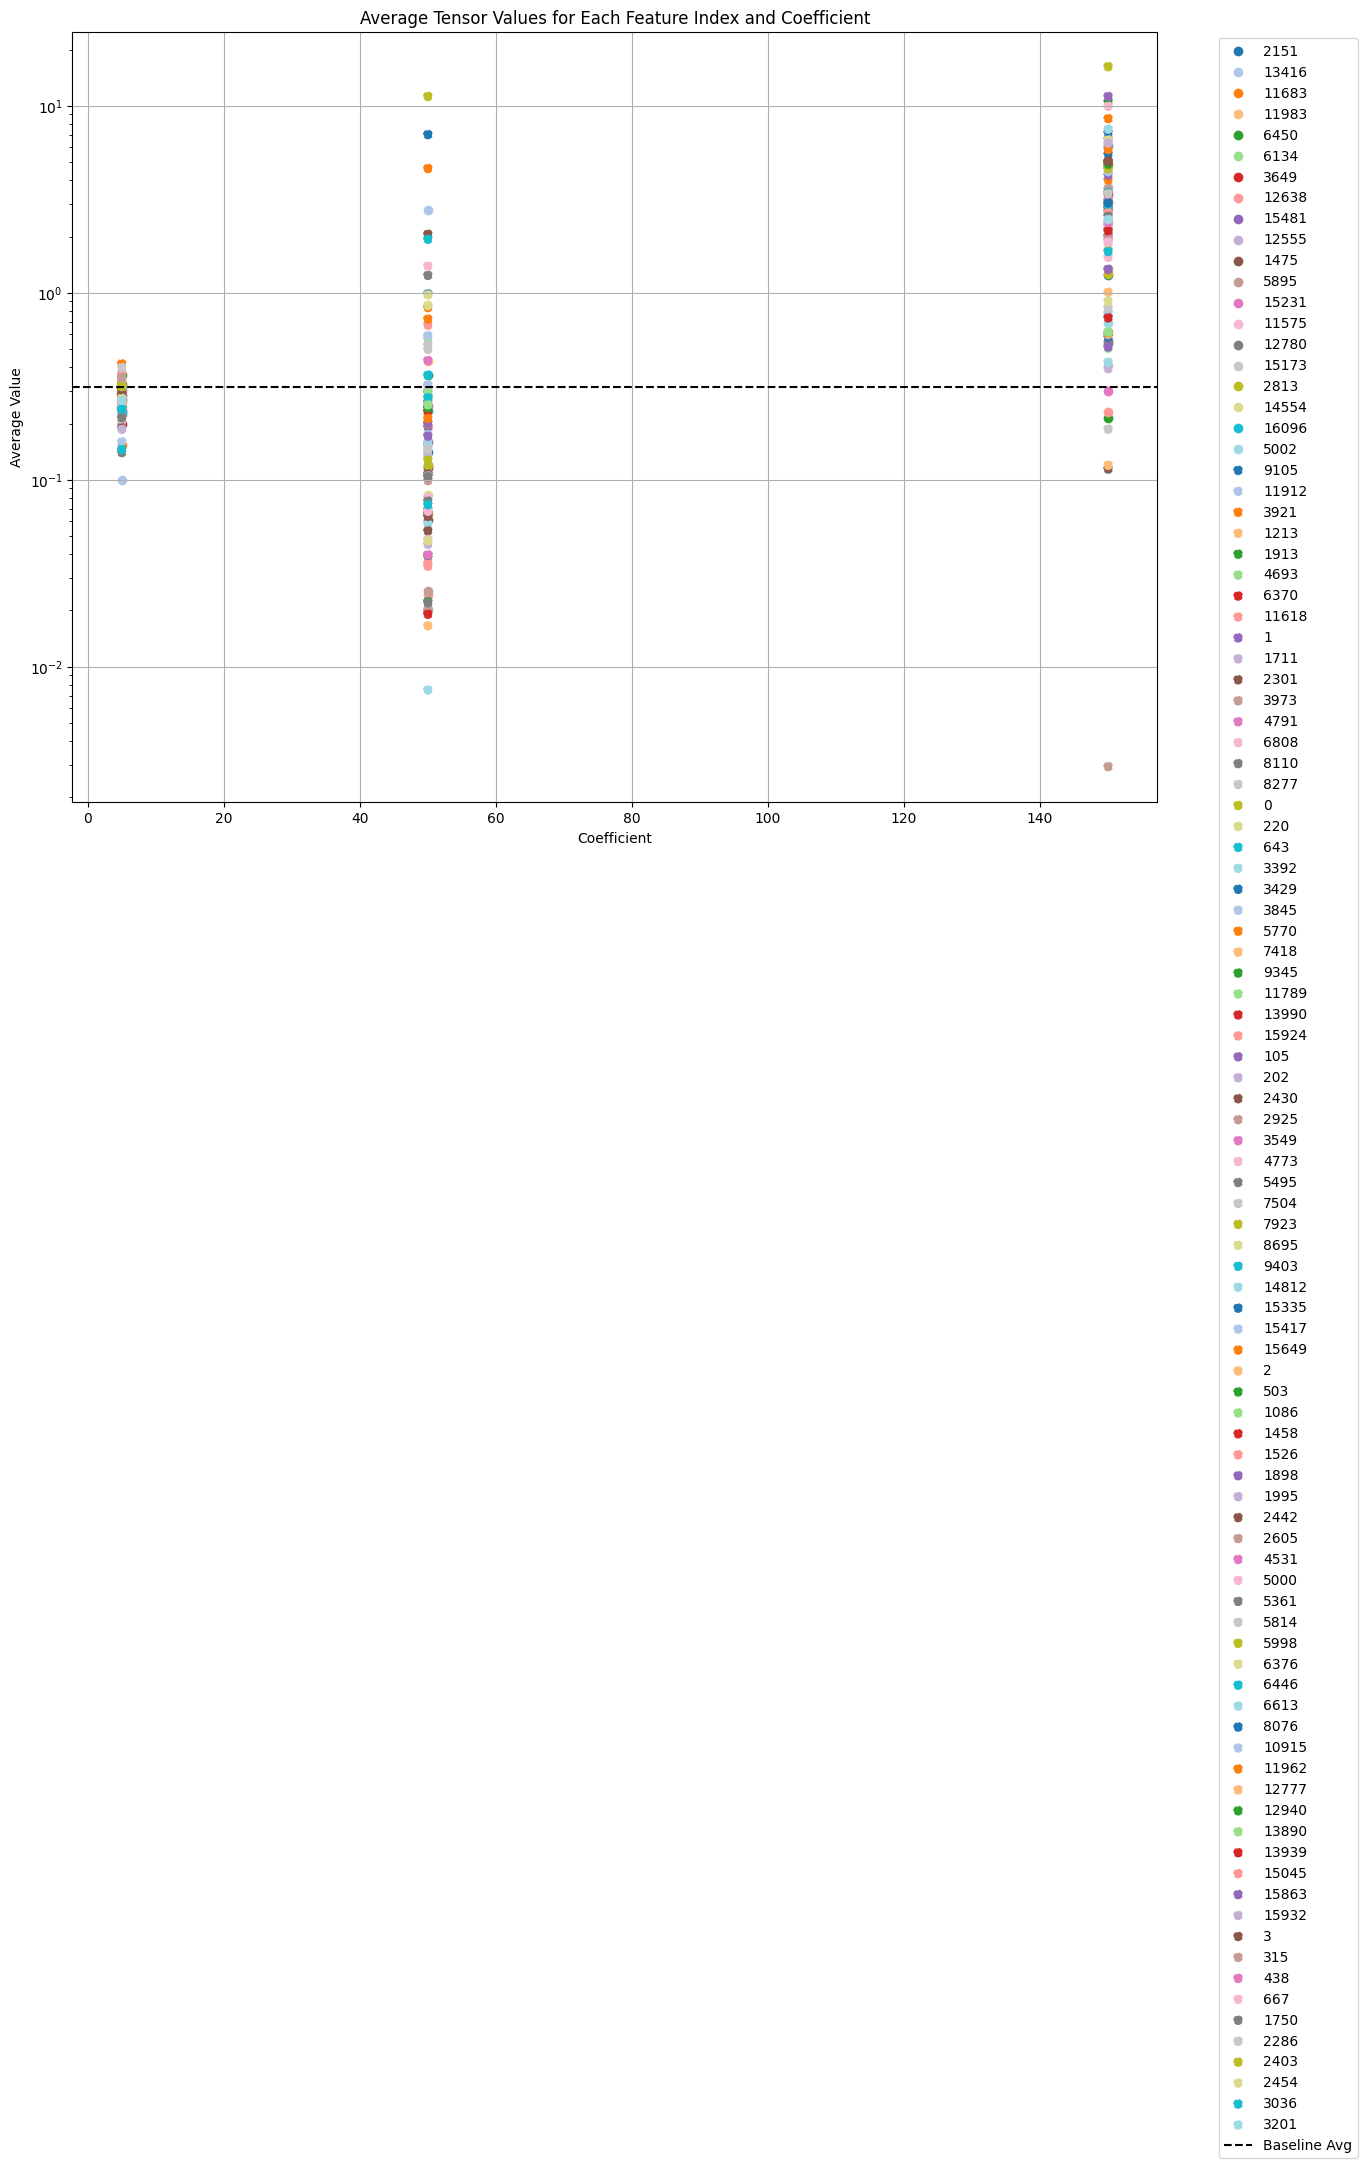

In [90]:
# Plotting
plt.figure(figsize=(14, 10))

# Create a colormap
cmap = plt.get_cmap('tab20')  # You can choose other colormaps if needed
num_colors = 20  # Adjust based on the chosen colormap

for idx, (feature_ind, coeff_dict) in enumerate(avg_dict.items()):
    coeffs = list(coeff_dict.keys())
    averages = list(coeff_dict.values())
    
    color = cmap(idx % num_colors)
    linestyle = '-' if idx < num_colors else '--'
    
    plt.scatter(coeffs, averages, label=feature_ind, color=color, linestyle=linestyle, marker='o')

# Plot baseline average value
plt.axhline(y=baseline_avg, color='k', linestyle='--', label='Baseline Avg')

plt.xlabel('Coefficient')
plt.ylabel('Average Value')
plt.yscale("log")
plt.title('Average Tensor Values for Each Feature Index and Coefficient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()

/home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/torch/cuda/memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/torch/cuda/memory.py:356: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [80]:
!nvidia-smi

Sun Jul  7 07:08:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:86:00.0 Off |                    0 |
| N/A   35C    P0              47W / 250W |  14132MiB / 40960MiB |     13%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
sv_prompt = "The Golden Gate Bridge"
sv_logits, cache = model_gemma.run_with_cache(sv_prompt, prepend_bos=True)
tokens = model_gemma.to_tokens(sv_prompt)
print(tokens)

# get the feature activations from our SAE
sv_feature_acts = sae.encode(cache[hook_point])

# get sae_out
sae_out = sae.decode(sv_feature_acts)

tensor([[    2,   651, 17489, 22352, 16125]], device='cuda:0')


In [37]:
steering_vector = sae.W_dec[10200]

example_prompt = "What is the most iconic structure known to man?"
coeff = 300
sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)

In [38]:
def steering_hook(resid_pre, hook):
    if resid_pre.shape[1] == 1:
        return

    position = sae_out.shape[1]
    if steering_on:
      # using our steering vector and applying the coefficient
      resid_pre[:, :position - 1, :] += coeff * steering_vector


def hooked_generate(prompt_batch, fwd_hooks=[], seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    with model_gemma.hooks(fwd_hooks=fwd_hooks):
        tokenized = model_gemma.to_tokens(prompt_batch)
        result, _ = model_gemma.run_with_cache(tokenized)
    return result

In [43]:
def run_generate(example_prompt):
    model_gemma.reset_hooks()
    editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
    res = hooked_generate([example_prompt] * 3, editing_hooks, seed=None)
    print(res.shape)
    # Print results, removing the ugly beginning of sequence token
    # res_str = model_gemma.to_string(res[:, 1:])
    # print(("\n\n" + "-" * 80 + "\n\n").join(res_str))

In [44]:
steering_on = True
run_generate(example_prompt)

torch.Size([3, 11, 256000])
